# Twitter Sentiment Analysis Stock Price Prediction

### - Crawl data

### - Sentiment Analysis

### - Predict Stock

## Import module

In [1]:
from textblob import TextBlob
import math
from collections import Counter, defaultdict
import tweepy as tw
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
%matplotlib inline
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

## Set up token API

In [2]:
api_key = "HAcIeikl6eRheQP1oKYGDwPx0"
api_secret = "gEWmqG7QVXzudnviUXDo98L2UKGYg9PNqy1bAR1geClkHjqBGk"
access_token = "1481095074465579008-1pApYlU4HRJWpbAXcbdVEVGzdACuEz"
access_token_secret = "htgD81H4mOxXw5MglAljFRHhcfGAuwsNomXVqvGw0Obwe"
auth = tw.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True)

## Crawl data

In [3]:
def apiSearch(kw, number_of_tweets, tweets, user_id, created_at):
    for i in tw.Cursor(api.search, q = kw , lang ="en", since = "2022-01-14",tweet_mode = "extended").items(number_of_tweets):
        tweets.append(i.full_text)
        user_id.append(i.user.id)
        created_at.append(i.created_at)

In [4]:
number_of_tweets = 500
tweets = []
user_id =[]
created_at = []
keyword_list = ['News', 'Stock', 'Customers', 'Employees', 'Company', 'Price', 
                'Shareholders', 'Market', 'Soaring', 'Trends']
company = 'Amazon'
final_kw_list = []

# Crawl data from keywords
for i in range (len(keyword_list)):
    kw = str(company + ' ' + keyword_list[i])
    print(kw)
    final_kw_list.append(kw)
    for i in tw.Cursor(api.search, q = kw , lang ="en", since = "2022-01-14",tweet_mode = "extended").items(number_of_tweets):
        tweets.append(i.full_text)
        user_id.append(i.user.id)
        created_at.append(i.created_at)



Amazon News
Amazon Stock
Amazon Customers
Amazon Employees
Amazon Company
Amazon Price
Amazon Shareholders
Amazon Market
Amazon Soaring
Amazon Trends


## Dataframe

In [5]:
df = pd.DataFrame({"Created_at": created_at,"User_id": user_id,"Tweets":tweets})
df

,Created_at,User_id,Tweets
0,2022-02-05 09:18:03,1463248168200642562,@LargeKnome @morgans_news @TheRealFam13 @Argen...
1,2022-02-05 09:15:23,2292454741,"Peloton (PTON) Draws Interest From Amazon, Oth..."
2,2022-02-05 09:14:45,167999129,RT @AFP: Rotterdam has not received a request ...
3,2022-02-05 09:14:11,1412422541507977225,RT @Investingcom: *AMAZON ADDS $190 BILLION I...
4,2022-02-05 09:14:02,102484501,RT @amazonwatch: Breaking news: Ecuador's high...
...,...,...,...
4434,2022-01-28 07:51:55,1475788576034107392,WARNING DESIGN ON AMAZON \nhttps://t.co/SV2w4W...
4435,2022-01-28 07:43:28,1486282899171205125,Tip for the day #amazon #amazonaffililate #ama...
4436,2022-01-28 05:50:10,1429692208475611138,🍁71% OFF ON-\n🍁Panash Trends Women's Embroider...
4437,2022-01-28 05:40:02,725751963049164801,https://t.co/hJq1HKacV7 Evil Eye Bead Bracelet...


## Clean data

In [6]:
df = df[~df.Tweets.str.contains("RT")]
df = df.reset_index(drop = True)

In [7]:
def cleanUpTweet(text):
    text = re.sub(r'@[A-Za-z0-9_]+','',text) # Remove mentions @
    text = re.sub(r'#', '', text) # Remove hastag symbol
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text) # Remove hyper link
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove special characters
    #Remove stop words
    res = ''
    for word in text.split():
        if word not in stopwords.words('english'):
            res += WordNetLemmatizer().lemmatize(word) + ' '
            
    return res

In [8]:
df['Tweets'] = df['Tweets'].apply(cleanUpTweet)
df = df.drop_duplicates(subset='Tweets')
df = df.reset_index(drop=True)
df

,Created_at,User_id,Tweets
0,2022-02-05 09:18:03,1463248168200642562,No one stopping Amazon Tencent Sony buying stu...
1,2022-02-05 09:15:23,2292454741,Peloton PTON Draws Interest From Amazon Other ...
2,2022-02-05 09:11:13,43861924,Amazon hike annual price Prime membership
3,2022-02-05 09:10:49,146690460,Donate 100 music sold thru amazon blm They nee...
4,2022-02-05 09:10:26,1267197215635726336,lt Ripple XRP Price gt XRP USDT Binance 0 6744...
...,...,...,...
1733,2022-01-28 08:05:00,1431299911,UAE Amazon subsidiary create cloud based medic...
1734,2022-01-28 07:51:55,1475788576034107392,WARNING DESIGN ON AMAZON warning nofilter NoFi...
1735,2022-01-28 07:43:28,1486282899171205125,Tip day amazon amazonaffililate amazonassociat...
1736,2022-01-28 05:50:10,1429692208475611138,71 OFF ON Panash Trends Women Embroidery Salwa...


## Create clean data list

In [9]:
cleaned_data=[]
for tw in df['Tweets']:
    cleaned_data.append(tw)
    
cleaned_data

['No one stopping Amazon Tencent Sony buying studio publisher ',
 'Peloton PTON Draws Interest From Amazon Other Suitors WSJ Reports AMZN Bloomberg ',
 'Amazon hike annual price Prime membership ',
 'Donate 100 music sold thru amazon blm They need mansion greedy Bezos ',
 'lt Ripple XRP Price gt XRP USDT Binance 0 6744 Check Price lt Headline News gt Couple dog rescued via helicopter stranded California cabin two month CNN xrp binance ripple Luka BullsNation ',
 'MacKenzie Scott Once Again Reminds People Jeff Bezos Is Cheapskate Comparison The Amazon founder given diddly squat charity compared ex wife ',
 'Is Amazon Prime Video TheBoys spinoff series dig Marvel animated series WhatIf Here think ',
 'lt Binance Coin Price gt BNB USDT Binance 425 1 Check Price lt Headline News gt Couple dog rescued via helicopter stranded California cabin two month CNN bnb binance binancepay Luka BullsNa ',
 'The news seconded Christchurch still jolt sent reeling emotionally beautifully crafted story EVE

## WordCloud Visualization

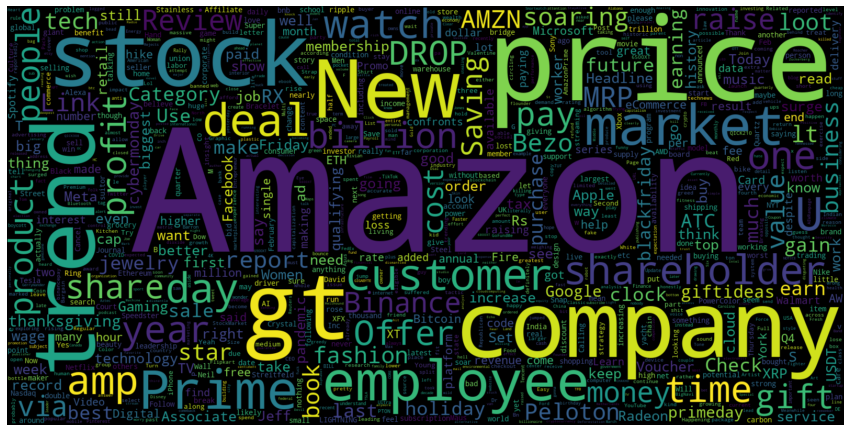

In [10]:
# Plot the word cloud 
allWords = ' '.join( [twts for twts in df['Tweets']] )
positiveWordCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(allWords)
plt.figure(figsize = (15,15))
plt.imshow(positiveWordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Sentiment Analysis

In [11]:
# Create function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Function compute negative, positive
def getAnalysis(score):
    if score < 0: 
        return np.int_(0)
    elif score > 0:
        return np.int_(1)
    else:
        return 'Neutral'
    
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)
df['Sentiment'] = df['Polarity'].apply(getAnalysis)
df.drop(df.loc[df['Sentiment']=='Neutral'].index, inplace=True)
df = df.reset_index(drop=True)
df

,Created_at,User_id,Tweets,Subjectivity,Polarity,Sentiment
0,2022-02-05 09:15:23,2292454741,Peloton PTON Draws Interest From Amazon Other ...,0.375000,-0.125000,0
1,2022-02-05 09:07:00,1308962606,The news seconded Christchurch still jolt sent...,1.000000,0.850000,1
2,2022-02-05 09:04:46,1221786728379404288,Floki Inu Flipped Amazon To Become Top Trendin...,0.500000,0.500000,1
3,2022-02-05 09:03:00,4833396790,The amount spent come combination original sho...,0.425000,0.137500,1
4,2022-02-05 09:00:49,146507470,BREAKING NEWS The ruled IN FAVOR Indigenous pe...,0.549107,0.142857,1
...,...,...,...,...,...,...
1058,2022-01-28 09:12:29,552106282,NLRB alleges Amazon broke law anti labor actio...,0.226515,0.078788,1
1059,2022-01-28 08:53:00,1274005629225623552,Focus AI 88 latest AI news 3 minute The larges...,0.391667,0.175000,1
1060,2022-01-28 08:07:14,1379478719086141445,Fitbit Sense Advanced Smartwatch Tools Heart H...,0.333333,0.083333,1
1061,2022-01-28 05:50:10,1429692208475611138,71 OFF ON Panash Trends Women Embroidery Salwa...,0.400000,0.150000,1


In [12]:
# Save as CSV file
df.to_csv('Amazon.csv')

In [13]:
# Display 5 positive tweets
j = 0
sortedDF = df.sort_values(by=['Polarity'])
positiveTweets = ''
for i in range(sortedDF.shape[0]):
    if sortedDF['Sentiment'][i] == 1:
        print(str(j) + ') ' + sortedDF['Tweets'][i])
        positiveTweets += (' ' + sortedDF['Tweets'][i])
        print()
        j+=1
    if j == 5:
        break



0) The news seconded Christchurch still jolt sent reeling emotionally beautifully crafted story EVERY FIVE MINUTES NewZealand novel Paperback NZ bookshop see Amazon print ebk FREEreadKU literaryfiction 

1) Floki Inu Flipped Amazon To Become Top Trending Asset Stocktwits Floki FLOKIINU FlokiVikings altcoin altcoins altcoinnews Crypto CryptocurrencyNews CryptoNews cryptocurrency news NewsAlert 

2) The amount spent come combination original show produced Prime Video paying musician Amazon music 

3) BREAKING NEWS The ruled IN FAVOR Indigenous people right decide future Amazon This massive victory fight climate change amp protection Indigenous people right 

4) Did know support Hand Hand whilst shopping Amazon Shop Amazon Smile support u every order additional cost Learn Find Hand Hand Amazon Smile 



In [14]:
# Display 5 negative tweets
j = 0
sortedDF = df.sort_values(by=['Polarity'])
negativeTweets = ''
for i in range(sortedDF.shape[0]):
    if sortedDF['Sentiment'][i] == 0:
        print(str(j) + ') ' + sortedDF['Tweets'][i] )
        negativeTweets += (' ' + sortedDF['Tweets'][i])
        print()
        j+=1
    if j == 5:
        break

0) Peloton PTON Draws Interest From Amazon Other Suitors WSJ Reports AMZN Bloomberg 

1) Sadly situation getting worse 

2) Missing profit 93 Amazon seller lost revenue supply chain disruption MakingWaves FreightIndustryNews 

3) Peloton share soar 30 amid report Amazon Nike want buy exercise bike firm Value fallen 8 billion 50 billion since pandemic fueled height via 

4) Amazon sleeping giant advertising wide awake 



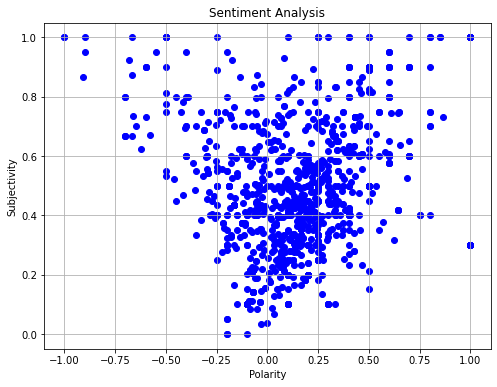

In [15]:
# Plot popularity and subjectivity
plt.figure(figsize=(8,6))
for i in range(df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='Blue')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.show()

## Train model

In [16]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [17]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [18]:
X = df['Tweets'].values
y = df['Sentiment'].values.astype('float')
RANDOM_SEED = 1
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [19]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)


In [20]:
y_pred = np.array(MNB.predict(X_test))
print(y_test)
print(y_pred)

[1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [21]:
accuracy_score(y_test, y_pred)

0.7417840375586855

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.04      0.07        57
         1.0       0.74      1.00      0.85       156

    accuracy                           0.74       213
   macro avg       0.87      0.52      0.46       213
weighted avg       0.81      0.74      0.64       213



In [25]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  2,  55],
       [  0, 156]], dtype=int64)

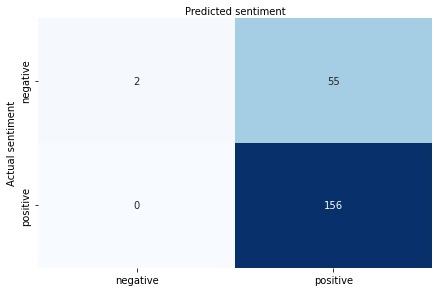

In [24]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');